<a href="https://colab.research.google.com/github/a-forty-two/DataSetsForML/blob/master/19_Revision_and_Completion_of_activity_Detection_and_TRANSFER_LEARNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# we will use a hardcoded video as test data
# if doing on laptop you can even use webcab for same program 
# as input stream 

# inputs were hardcoded,video is not a user input but an mp4 or avi file

# Algorithm
# 1. Input a video (or live stream)
# 2. open the frames as images
# 3. Run object detection on images to understand continous usage of objects (RESNET/VGG)
# 4. Continous usage of objects is called ACTIVITY
# 5. in each frame of video, classify the frame as an activity
# 6. combine the frames back into a video to deliver as classified output! 



In [0]:
######## start of: TRAIN.py

# WHEN DEVELOPING-> import only when required
# - minimize program size - control over 3rd party components
# WHEN in production-> include all libraries in the beginning of program 
# itself
# - minimize LATENCY - all mandatory components should be available before 
# execution starts 
# Sometimes all libraries are written in a single config or dependency
# or include file
# this is just to minimize "typing" size, no impact on program because
# while execution, your library will be copy-pasted with its source. 


from keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pickle # to read/write binary files as dumps (for weights and biases or binarized labels)
import cv2
import os # os.separators to separate path names and get file name and file folder name
from keras.applications import ResNet50
# to customize models with own layers
from keras.layers.core import Flatten, Dropout, Dense
from keras.layers.pooling import AveragePooling2D # AVERAGE pixel -> do this when color of object shouldn't matter 
from keras.layers import Input # input layer can take general or any input size (dynamic input size but once decalred cannot be changed)
from keras.models import Model
#label binarizer to encode/decode binarized outputs 
from sklearn.preprocessing import LabelBinarizer
import imutils
from imutils import paths
# but what if i wanted to take average without losing channels?
# Conv2D -> GlobalAveragePooling-> Conv2D would split data into R, G and B channels 
# then GAP will calculate averages for R, G, and B separately thus preserving colors 
from keras.optimizers import SGD
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import random

In [0]:
# variables that should have been collected from user through UI or command line or API post
dataset = 'data'
model_path = 'bin'
binarizer_path = 'bin'
evaluation_path = 'eval'
test_path = 'test'
# directory structure required
# myactivitydetector.py --dataset data --bin bin --eval-data eval --test-data test

In [10]:
# shuffle the data after reading all paths

imagePaths = sorted(list( paths.list_images(dataset)))
random.seed(42)
random.shuffle(imagePaths)
imagePaths[:2]

['data/weightlifting/00000147.jpg', 'data/hockey/00000009.jpg']

In [0]:
# need to conver to img_to_array and resize 
# this is how to use ResNET 
# in our VGG-> we took (96,96,3)
# larger images are required because smaller image= not enough filters possible
label_names = ["weightlifting","swimming","hockey","basketball"]
labels = []
data = []
for path in imagePaths:
  label = path.split(os.path.sep)[-2] # folder name! to represent class name 
  if label not in label_names:
    continue
  labels.append(label)
  img = cv2.imread(path)
  # ResNet requires this to be done- rearranging the channels and making sure its R,G,B in this format and not B,G,R
  # ImageNet-> means -> separate means for R,G,and B!!! their channel positions are also hardcoded!
  # so if this was not done to an image, the logic of R will be applied to B and vice versa!! 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # these are simple reshape, resize and expand_dims functions
  img = cv2.resize(img, (224,224)) 
  data.append(img)
  # RESNET model -> input size (224,224,3) , only accept RGB channel, while most images
  # like jpeg, png, jpg, giff are arranged in BGR (just opposite)
  # Object detection -> there order of the color did  not matter because RGB values combined would have 
  # resulted in same color anyway 
  # just in case error handling-> if image is already RGB, the below function will do nothing, if its BGR, it will
  # be converted to RGB 
  
  # they readjust dimensions to fit various frameworks 
  # RESNET doesn't require image aug sep because it was inbuilt into its architecture 
  # aug.flow-> model.fit_generator 
  

In [0]:

data = np.array(data)
labels = np.array(labels)
lb = LabelBinarizer() # LABELS were converted into 1-hot matrices instead of label encoded (categorical label data) 
# if one-hot columns on input data-> ONE-HOT encoding (it generates new columns out of categorical input data)

# 5 encoding-> LabelEncoders, One-Hot, Multi-Hot, LabelBinarizer, Word2Vector 
# Label Encoder-> no statistical relationship between data, and only positional representation was required
#        Sentiment Analysis, Topic Understanding, Encryption/Decryption, Language/Machine translation 
#        Preserves word as a token, not meant for categorical data (but can be used in simple binary classification 0-1)


# Customer_problem     Category_problem    SolutionSuggested (label)
# lost my card          card-related             CardsTeam 
# missed my EMI         loan-related            LoansTeam
# new credit card       card-related            CardsTeam
# random deductions     card-related            Security Team       

# customer problems are continous english statements -> for their encoding I have 2 choices 
#        Label Encoding, Word2Vector 
# category problem is an input categorical column (all values are INDEPENDET of each other within a column). This 
#       column should ideally be used for filtering. The best way of filtering with minimal programming-> one-hot encoding 
# Solution suggested is the LABEL or output. For its encoding I have 2 choices
#        label encoder, Label Binarizer 
# If it is a prediction-on-input problem, like autocomplete, spell check, sentence completion, word prediction 
# I need a VECTORS capable of changing vectors when word is used in various positions and sequences 

# how do i select length or granularity of these vectors? Should be they sentence, words, characters, pages? 
# what shold be the segmentation size?
# WHEN USING PATTERNS FOR PREDICTION-> large patterns detect small objects, small patterns detect large object
# Smallest pattern in string is a CHARACTER
# that's why character level Seqence-2-sequence mapping is preferred 

# when encoding "I am going home"
# I's vector is independent-> because it is starting vector
# but the vector for 'o' on 7th position and 13th position is built up of sequences just before them 
# the 7th position's vector has been calculated wrt 'I am go' and not just 'o' alone. 





# LABEL BINARIZER is MATHEMATICALLY massively more optimized and faster to calculate than other data structures
# MATRICES -> very close to NUMPY and thanks to numpy, their operations are very fast in most languages 
# Label Encoding CANNOT be used for MULTI-CLASSIFICATION but Label Binarizer can be! multiple columns hot on a single
# row indicate multiple classification:   [ [1 0 1], [0 0 0], [ 1 0 1]] (multi columns hot)




# One-hot and Multi-hot encoding -> ONLY on INPUT categorical data. Why not regression? Because it will take all 
#        unique values, and make them columns! It is very likely that most values are unique!!! 
#        Sales predictions (region specific), FILTERING of input data, wherever input categories were independent of 
#         each other (profits in Russia cannot be predicted the same way as Europe!)
#        Onehot or multi-hot encode-> FILTER the data or let weights be considered as 0 -> do individual learning on
#         each encoded category seperately 
#        It is NOT used for word or char or sentence tokens! 

# Label Binarizer -> ONLY on OUTPUT (labelled) categorical data. Why not regression? same reason as one-hot encoded 
#         Scenarios to use it: When output categories are independent of each other, and input may carry more than
#         one output (an image can contain multiple objects that can be detected)
#         Object detection, activity detection, advanced multi-class classifications
#         DIFF from One-hot-> done on output not input, does not create new columns in
#                             dataset-> creates new columns in matrix instead



labels = lb.fit_transform(labels)
labels # HOT-encoded MATRIX 
(xtrain, xtest, ytrain, ytest) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42 )
# << left shift operation
#       0 0 0 1  0 0 0 0   -> left shift by 2 - >   0 1 0 0 0 0 0 0 
#          -> right shift by 1 -> 0000 1000 
# This label binarizing is EXTREMELY FAST because of LEFT shift operations which happen at bit-level 
# there is no need to go through the entire list of items, just need to know HOW many items

In [0]:
# split into train/test
# whenever we need classes balanced while splitting, we use a process called 'stratification'
# it shuffles on the basis of types of output labels, and not just random_state
(xtrain, xtest, ytrain, ytest) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42 )

In [0]:
trainAug = ImageDataGenerator(rotation_range=25, zoom_range=0.20, width_shift_range=0.2, height_shift_range=0.2, 
                              shear_range=0.20, horizontal_flip=True, fill_mode='nearest')

valAug = ImageDataGenerator() # default augmentation (everything is set to false-> no augmentation)
# this will help validate the model in 2 augmentation- one with our v/s with any other option! 
# these values are for R, G and B respectively. This is the reason why we had to make sure all images are 
# only RGB and not BGR. Else wrong mean values would have been considered for loss calculation. 
means = np.array( [ 103.939, 116.779, 123.68 ])
trainAug.mean = means
valAug.mean = means 
# deviations will be calculated from respective means
# train data -> trainaug.means
# valdata -> valAug.means 

# Since the data is augmented and no longer the original image, the difference between the original image (no aug- val)
# and augmented image (trainAug) can be calculated as difference in the mean 
# when using keras.application 
# To find out this mean there are various formula, but we are going to use the preferred production method-
# WITH RESNET and VGG, we use means from 'ImageNet'. 
# 3 averages-> 1 each for R, G and B 
# From scratch way is to calculate it based on your data. BUT, when doing transfer learning, follow what model
# says. VGG and Restnet for 'ImageNet' standards. 




In [15]:
# LAST time-> we built our own PandaVGG, THIS time-> transfer learning using ResNet 
# Last time-> we calculated our weights for PandaVGG, THIS TIME-> preserved ResNet's weights by setting 
# non trainable layers 
# REST of it is EXACTLY the same except hyperparameters 






# cloud -> hadoop (parquet) -> g(s3) -> no bigquery
# PySpark notebooks -> external tables -> DataBricks 
# Transfer learning and build our model on top of it
basemodel = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
# include top = False -> i am going to provide my own top-layers, the default ResNet top layers are not requried
# (top layers are the ones on right)
# name: Left side of model is called BASE or BOTTOM, the right side of model is called a HEAD or TOP

# if i am importing my weights from ImageNet-> then during learning, all this will be recalculated and transfer-learning
# will be lost!!!! That is why, when Transfer Learning, ALWAYS make sure that transfered layers' learning is set
# to false 

# activity detection and classification model
# use object detection as base algorithm and build your own algo on top of it 
# basemodel was loaded as KNOWLEDGE, myModel is the 'Head' or 'Top' model 
myModel = basemodel.output # TRANSFER LEARNING (Knowledge transfer) is done 
# another of adding layers besides model.add
# MATMUL way -> multiplicative way of adding layers (because anyway between layers its the mul, inside layers-> add)
# model  = (additive_layers)(model)
# MATMUL is nump matrix multiplication 
# NEURAL -> playing with TENSORS-> only 2 ops-> Add (inside a layer), Mul (between the layers) 
myModel = AveragePooling2D(pool_size=(7,7))(myModel) # in matmul AXB != BXA, same as model.add(AvgPool2D)
#Pattern recognition 
# till now my data is 2 d! Image Pattern Recog
# Flatten -> Dense(ReLu) -> Dense (Softmax)


# a= a+b, a+=b <- diff methods of doing the same thing
# a++, a=a+1

# Add, Mul -> y = weights*x + bias 
# y = w1*x1 + w2*x2 + w3*x3 + bias 

# model.add () -> this is not addition, this means add the layer next to it (which would be multiplication)



# ways to add layers in Keras
# 1. Model.add
# 2. MatMul way -> either add inside layer or multiply between layers 
# 3. Class Derivation -> SIMILAR approach to what we did with VGG except this also includes Inheritence 
# from keras' model class 

#class MiniVGGNetModel(Model):
#	def __init__(self, classes, chanDim=-1):
#		# call the parent constructor
#		super(MiniVGGNetModel, self).__init__()


# https://www.pyimagesearch.com/2019/10/28/3-ways-to-create-a-keras-model-with-tensorflow-2-0-sequential-functional-and-model-subclassing/

myModel = Flatten(name='flatten')(myModel) # specific names to layers, you can do so by name property
myModel = Dense(512, activation='relu')(myModel)
myModel = Dropout(0.3)(myModel) # regularization- to avoid overfitting 
myModel = Dense(len(lb.classes_), activation='softmax')(myModel)

# what are the various ways to avoid overfitting?
# 1) REGULARIZATION -> L1, L2, Dropout, Early Stopping (Median, Bandit, Truncation, Patience) [manual initially, but best automated]
# 2) bias-variance tradeoff (adjust the values) [automated]
# 3) hyperparamter tuning (adjust the values) [Grid Search, Random Search]
# 4) Data Augmentation (word2Vectors, Noise, Image Augmentation, image overlays, filters, video mixers) (manual)
# 

# Early stopping -> tf provides patience-> this is the continuous epochs for which a model will perform poorly 
# Better strategies-> RUN multiple algorithms in parallel, and early stop COMPARITIVELY poor performing algorithms
#      1) MEDIAN early termination: FIND out the average performance of all algorithms, and terminate all below the 
#                 median performance (example: 30%, 40, 60, 62, 63). Here median is 60, so the first 2 algos are dropped
#                 # YES, these are repeated and median keeps shifting 
#      2) TRUNCATION policy: tf patience style- based on absolute performance measure for a continous time period
#                 example: threshold was 80%, and perfor: 30%, 40, 60, 62, 63, then all algos would be dropped!!!
#      3) BANDIT policy-> over here the minimum performance threshold is set by us. All algos performing below it will
#                 be terminated -> truncation's problem solved-> instead of absolute threshold, a dynamic threshold 
#                 is calculated. 

# most human effort should be focused on 3 and 4 
# 1 and 2 can be automated, and there are many algorithms that will do it better than we can 
# https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters 

# HPs are Learning Rate, Epochs, Layers, hidden dimensions, number i can play around with and change model 
# performance 
# less or more data-> HP tuning is ALWAYS required 
# Hyperparameter tuning is painful task-> INFINITE POSSIBLE COMBINATIONS that could have been used
# there is NO perfect answer in some cases! 
# Quest is to find either the BEST answer or a WORKABLE answer 
# if you want to find best answer, then the search-space for hyperparams has to be finite (SARIMAX=> (1,0,1,1)X(0,1,1))
# Grid Search is to find best answer 
# it creates an EXHAUSTIVE truth table generating ALL combinations of Hyperparams, so just choose Min or Max 

# Random Search is to find workable, but not the best paramters- idea is to find something quickly 
# and move on -> it is done wherever Hyperparameter search space is INFINITE 
# Example: In most cases!!!! Grid search is exhaustive, time consuming and sometimes very expensive on big data
# some grid search calculcations (enc/dec) can cross 1 BILLION years of computer/math time to calculate


# in Resnet-> the mean values taken from ImageNet are global standards. So i as user will not be able to calculate
# better means, because for that i will require all images on internet!!! 
# Global standards -> average for R,G and B are different (of course!)
# if i change the positions of channels, than Blue channel could have got divided by mean from green channel which 
# would defeat the purpose of calculating mean from global data!!!!

# in PandaVGG that we built-> we just mantained it via Channel Dimension = channels_first or _last
# after that-> we calculated our averages per layers and didn't worry about whether it was RGB or BGR or any other format


# model = basemodel + yourModel 
model = Model(inputs=basemodel.input, outputs=myModel) # connection of the two pipes -> ResNet and Mymodel 

for layer in basemodel.layers: # ResNet parameters should be preserved, and not learnt again
  layer.trainable = False 
# Learning will be ONLY for myModel not for basemodel-> resnet weights will be preserved, while myModel will keep 
# learning 
# PARTIAL LEARNING-> some part of model is already smart, some part is learning from it's smartness 

# EVERYTHING is a GAME -> with outcomes, consequences and Players. 
# 2 kinds of games-> Zero Sum (win-win : clustering, encoding)
# , non-zero sum (winners/losers- chess, classification, cross entropy, elections)

# IF NOW YOU WANT MODEL TO BE FAMILIAR WITH YOUR IMAGES, you need to show images again!
# but this brings us a problem- if i retain the model -> then the imagenet weights will be recalculated!

# every time back-prop -> weights and bias are recalculated
# everything that i inherited from resnet will GO AWAY except its shape!!
# TO PRESERVE THE WEIGHTS INHERITED you can set that layers will NOT be learnt upon
# thAT means their parameters will be unaffected by gradient descent 









/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#model.summary()
# Non trainable parameters-> non trainable ResNet which has layer.trainable = False 
# trainable params -> Dense layers towards the top, which is myModel 

In [20]:
# what's the advantage of these non trainable parameters that we have inherited from Resnet/Imagenet 
# we are using Transfer Learning because these models already have been trained on MILLIONS of images
# and already have weights that can help identify most of the objects 
# hence we can use them to generate weights for our problem and just manipulate them to the results what 
# we want. 
# if i retrain, then i lose information (w,b) on all previously trained images! 
# if i had to do that, i could have built a new model from scratch instead!!

#Hyperparams
HP_init_lr = 1e-4
HP_epoch = 50
HP_momentum = 0.9
HP_batch_size = 32


# MOMENTUM -> force + direction (vector gradient, not a scalar gradient descent )
opt = SGD(lr=HP_init_lr, momentum = HP_momentum, decay= HP_init_lr//HP_epoch)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(trainAug.flow(xtrain, ytrain, batch_size=HP_batch_size),
                              steps_per_epoch = len(xtrain)//HP_batch_size,
                              validation_data=valAug.flow(xtest, ytest),
                              validation_steps = len(xtest)// HP_batch_size,
                              epochs= HP_epoch)

# CONVOLUTION layers even though are not fully connected, tend to perform better than 
# fully connected (Dense) layers, because of long sequences and knowing only partial info 
# of the patterns. This behavior can be even further enahnced by making sure that enough dropouts
# and sufficiently long chains of conv2d are present 
# it's usually a good idea to compress or enlarge the pattern and start with SMALL patterns on 
# large data. THen in later layers, detect LARGE patterns in small (compressed) data. 


Epoch 1/50
17/17 [==============================] - 172s 10s/step - loss: 1.6136 - acc: 0.2778 - val_loss: 1.6074 - val_acc: 0.2109
Epoch 2/50
17/17 [==============================] - 165s 10s/step - loss: 1.4543 - acc: 0.2791 - val_loss: 1.4755 - val_acc: 0.2613
Epoch 3/50
17/17 [==============================] - 166s 10s/step - loss: 1.3089 - acc: 0.4127 - val_loss: 1.2552 - val_acc: 0.3784
Epoch 4/50
17/17 [==============================] - 165s 10s/step - loss: 1.2125 - acc: 0.4174 - val_loss: 1.1585 - val_acc: 0.4865
Epoch 5/50
17/17 [==============================] - 164s 10s/step - loss: 1.0875 - acc: 0.5373 - val_loss: 1.0246 - val_acc: 0.5405
Epoch 6/50
17/17 [==============================] - 173s 10s/step - loss: 0.9964 - acc: 0.6011 - val_loss: 0.9338 - val_acc: 0.6328
Epoch 7/50
17/17 [==============================] - 162s 10s/step - loss: 0.9200 - acc: 0.6636 - val_loss: 0.8429 - val_acc: 0.6757
Epoch 8/50
17/17 [==============================] - 164s 10s/step - loss: 0.

               precision    recall  f1-score   support

   basketball       0.82      0.94      0.88        35
       hockey       0.92      0.92      0.92        39
     swimming       0.97      0.94      0.95        31
weightlifting       0.94      0.84      0.89        38

     accuracy                           0.91       143
    macro avg       0.91      0.91      0.91       143
 weighted avg       0.91      0.91      0.91       143



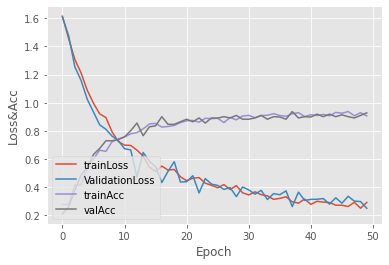

In [24]:
predictions_binarized = model.predict(xtest, batch_size=HP_batch_size)
# some metrics out of it 
# EXACTLY this way -> logo
# dataset -> myLogo (1000 samples), otherLogo (2000)
# EXACT-> image processing -> image_agumentation(logo) -> subset(main_image_augmentations)
# for exact match, ML is a bad idea-> why? because cross entropy! we are okay with loss,
# while for exact match, loss->0 

# could've used ytest directly, but it is a matrix (binarized), classfication_report is built
# only for flat values. [0 0 1] <- 3rd value is the correct class
report = classification_report(ytest.argmax(axis=1), predictions_binarized.argmax(axis=1),
                               target_names=lb.classes_) # inbuilt np.argmax -> gives index of max
predictions = predictions_binarized.argmax(axis=1)
# ALWAYS KEEP THIS while using LABEL BINARIZER

print(report)

# plot the history to diagonize performance
N = HP_epoch
plt.style.use('ggplot') # borrowing a style library 
plt.figure()
plt.plot(np.arange(0,N), history.history['loss'], label='trainLoss')
plt.plot(np.arange(0,N), history.history['val_loss'], label='ValidationLoss')
plt.plot(np.arange(0,N), history.history['acc'], label='trainAcc')
plt.plot(np.arange(0,N), history.history['val_acc'], label='valAcc')
plt.xlabel('Epoch')
plt.ylabel('Loss&Acc')
plt.legend(loc='lower left')
plt.savefig(evaluation_path+'/history.png')
plt.show()




# this graphs shows an example of very good training, where more epoch and a larger dataset
# could have taken the performance 95% +


In [0]:
model.save(model_path + '/model.h5')
# save the binarized labels
f = open(model_path+'/labels.pkl', 'wb')
f.write(pickle.dumps(lb))
f.close()
# model and labels saved for future use 
# train.py ends here

In [0]:
# Prediction of activities 
# Score.py begins here

from keras.models import load_model
from collections import deque 
import numpy as np
import pickle
import cv2


In [0]:
UI_model_path = 'bin/model.h5'
UI_labels = 'bin/labels.pkl'
UI_input_video = 'test/example_activities.mp4'
UI_activity_frame_length = 128 # come back and change this number
# we are assuming an activity lasts for 32 frames on the video to be detected as a pattern 
# Speed = distance/ time 
# FPS = Frames / video_length 
# distance = speed X time 
# 20 FPS = 20 frames in 1 second, for a video length of 1 min= 20 X 60 = 120 frames 

# ROLLING WINDOW on our video and detect activities inside that window
# Detect activity for each frame inside the rolling window, and using a statistical method
# can decide average or majority or minority activity 

In [0]:
model = load_model(UI_model_path)
lb = pickle.loads(open(UI_labels,'rb').read())
UI_activity_frame_length = 128
# QUEUE of frames and detect pattern a rolling-window on it? 
# average pixel values from ImageNet
mean = np.array( [ 103.939, 116.779, 123.68 ]).astype('float32')
q = deque(maxlen=UI_activity_frame_length)
# dynamic queue, a type of data structure


In [0]:
# consume the video and break into frames 
from google.colab.patches import cv2_imshow
vs = cv2.VideoCapture('test/180301_01_B_Basketball_13.mp4')
# initialize an empty writer_pointer and empty frame, to write output frames
writer = None
(W,H) = (None, None)

while True:
  # read a frame
  (grabbed, frame) = vs.read()
  if not grabbed: # End-of-line or \0 or NULL or images 
    break
  # if frame is empty, intialize frame, if already initialized, continue with that frame
  if W is None or H is None:
    (H,W) = frame.shape[:2] # gives first 2 elements which are arranged in height, width format
  output = frame.copy()
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  frame = cv2.resize(frame, (224,224)).astype('float32')
  # calculate mean error from the ImageNet means
  frame -= mean 
  corrected_frame = np.expand_dims(frame, axis=0)
  # a healthy, processed frame ready for my model 
  preds = model.predict(corrected_frame)  # this will be a LIST of binarized items, inside another list 
  img_prediction = preds[0]
  q.append(img_prediction) 
  # added data to rolling window, and calculate new rolled-average 
  results = np.array(q).mean(axis=0)
  i = np.argmax(results)
  label = lb.classes_[i]
  # label name achieved 
  
  # let's update our empty frame!!!
  # the axis images follow-> left to right-> positive, top to bottom-> positive
  # right to left /  bottom to top -> neg
  text = label + " Detected!"
  cv2.putText(output, text, (35,35), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,0,0), 5)
  # 35,35 is text to left,top
  if writer is None:
    # fourcc is the encoding 4 bytes used by MPEG videos 
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")  # building encoding
    writer = cv2.VideoWriter('bin/output_b.avi', fourcc, 30, (W,H))
  writer.write(output)
  #cv2.imshow(output)

  # take a user input to exit, lets say x to exit 
  key = cv2.waitKey(1) & 0xFF # correct way of taking user input from openCV 
  
  if(key == ord('x')): # converts the cv2 output to the respective integer, all chars are numbers
    break


writer.release()
vs.release()
# ALL SOUND WILL BE LOST IN THE RESULTING VIDEO
# IF original video had any sound, it should be overlayed
# separately 
# this is possible as long as there is no compression/decom
# on image size or Frames-per-second
# otherwise sound and video will desync! 
# TOTAL PLAYING TIME of audio and video cannot change for overlay
# to happen without data loss 



  # make sure you do this whenever taking user input from OPEN CV-> camera
  # for portability, make sure that this works for both 16 bit or above it
  # if i had to represent, 1, then 01, 00 01, 0000 0001 are all same-> their lowest signifact
  # byte is 1 hence i could have just looked at the last number 
  # for 16 bit, i can take lower two bytes of data! 
  # can be achieved through AND operation with 1111 1111 !
  # 0101 0101 1010 1010 (large data piece!)
  #     0101 0101 1010 1010  
  # &             1111 1111
  # r=  0000 0000 1010 1010   <- last 1 byte got saved! 
  # to save 16 bits, filter should be 1111 1111 1111 1111!
  # in hexadecimal, we can refer to this as F F 
  # hex(0xF)  = 1111 1111
  # hex(0xFF) = 1111 1111 1111 1111





  # Since this is a video, it will come to an end 
  # if this was a live feed or a webcam, then we should also have a way to exit, because this
  # will become an infinite loop 







In [23]:
# link to previous tests
# https://1drv.ms/u/s!AhM-uOEWdqAexFdgz8rD6bB5LNMQ?e=UrYZDi 


model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
# data can be downloaded from
# https://1drv.ms/u/s!AhM-uOEWdqAesjQePSPc7XqEp7ox?e=bUsSuS